# Classification model for Penguins dataset
> Data analysis and visualisation 
> Data cleaning
> Dividing dataset for train and test one
> Using a few ML models to find the best one for assigning species 
> Analysis and conclusions


*Creators:*  

**Piotr Piotrowski** \
**Karolina Krzyżagórska**

In [1]:
%pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import time


In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [5]:
## Loading data and first look

pin = pd.read_csv('penguins.csv')
print(f"pin dimensions are (rows x cols) {pin.shape}")
pin.head(10)

pin dimensions are (rows x cols) (344, 7)


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,FEMALE
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,MALE
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


In [6]:
pin[['species','island', 'sex']].value_counts()

species    island     sex   
Gentoo     Biscoe     MALE      61
                      FEMALE    58
Chinstrap  Dream      FEMALE    34
                      MALE      34
Adelie     Dream      MALE      28
                      FEMALE    27
           Torgersen  FEMALE    24
                      MALE      23
           Biscoe     FEMALE    22
                      MALE      22
Gentoo     Biscoe     .          1
dtype: int64

In [7]:
## Replace dot and show some summary calculations

pin.sex.replace('.', np.nan, inplace=True)
print(pin.describe())
print(pin.info())

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        342.000000       342.000000         342.000000   342.000000
mean          43.921930        17.151170         200.915205  4201.754386
std            5.459584         1.974793          14.061714   801.954536
min           32.100000        13.100000         172.000000  2700.000000
25%           39.225000        15.600000         190.000000  3550.000000
50%           44.450000        17.300000         197.000000  4050.000000
75%           48.500000        18.700000         213.000000  4750.000000
max           59.600000        21.500000         231.000000  6300.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64

In [8]:
## Count null rows in every column

pin.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [9]:
##Adding column with count of null values in a row

pin['NaN'] = pin.isna().sum(axis = 1)
pin.sort_values(by=['NaN'], ascending=False).head(15)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,NaN
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,5
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN,5
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN,1
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,1
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN,1
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN,1
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,1
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,1
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,1
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN,1


**Some conclusions:**
1. we will be dealing with missing data (NaN's)
2. "sex" column can be changed to 0|1 values
3. there are not a lot of NaNs - good
4. there are only 2 rows w/o any data (#3 & # 339) - we can get rid of them
5. other missing data is in 'sex' column, in two species, we can try to fill those missing data basing on other columns (correlation between weight and place of living)
6. there's one fun thing - row 336 (this came out while executing #in41 but I'll leave it here), besides NaNs we hava false data here - we'll handle this the same way as NaNs.

In [10]:
##Delete rows with 5 nulls

pin=pin[pin['NaN'] != 5]

pin.sort_values(by=['NaN'], ascending=False).head(15)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,1
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,1
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN,1
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN,1
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,1
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,1
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN,1
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN,1
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN,1
231,Gentoo,Biscoe,49.0,16.1,216.0,5550.0,MALE,0


In [11]:
# we still have missing data in 'sex' column, let's see how they look
pin[pin['sex'].isna()]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,1
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,1
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,1
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,1
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN,1
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN,1
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN,1
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN,1
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN,1


In [12]:
# would there be any correlation between i.e. land, body mass etc...?
# we should set i.e. 'sex' to "isMale", but this approach is a bit faster
# we'll use .corr method for this, but first we need to change 'sex', 'species' and 'land' to integer values, let's do it:
tmp = pin.copy(deep=True)
tmp['sex'] = tmp['sex'].astype('category')
tmp['species'] = tmp['species'].astype('category')
tmp['island'] = tmp['island'].astype('category')
catCoumns = tmp.select_dtypes(['category']).columns
tmp[catCoumns] = tmp[catCoumns].apply(lambda c: c.cat.codes)
# 'sex' column right now is in numerical data type, let's see it:
tmp

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,NaN
0,0,2,39.1,18.7,181.0,3750.0,1,0
1,0,2,39.5,17.4,186.0,3800.0,0,0
2,0,2,40.3,18.0,195.0,3250.0,0,0
4,0,2,36.7,19.3,193.0,3450.0,0,0
5,0,2,39.3,20.6,190.0,3650.0,1,0
...,...,...,...,...,...,...,...,...
338,2,0,47.2,13.7,214.0,4925.0,0,0
340,2,0,46.8,14.3,215.0,4850.0,0,0
341,2,0,50.4,15.7,222.0,5750.0,1,0
342,2,0,45.2,14.8,212.0,5200.0,0,0


In [13]:
# and finally let's see the corr() output. A positive value for r indicates a positive association, and a negative value for r indicates a negative association.
tmp.corr()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,NaN
species,1.000000,-0.633150,0.731369,-0.744076,0.854307,0.750491,0.012056,-0.005393
island,-0.633150,1.000000,-0.353647,0.571035,-0.565825,-0.561515,-0.044731,0.077150
culmen_length_mm,0.731369,-0.353647,1.000000,-0.235053,0.656181,0.595110,0.340289,-0.079067
culmen_depth_mm,-0.744076,0.571035,-0.235053,1.000000,-0.583851,-0.471916,0.348055,-0.042246
flipper_length_mm,0.854307,-0.565825,0.656181,-0.583851,1.000000,0.871202,0.235358,-0.022424
body_mass_g,0.750491,-0.561515,0.595110,-0.471916,0.871202,1.000000,0.396042,-0.040279
sex,0.012056,-0.044731,0.340289,0.348055,0.235358,0.396042,1.000000,-0.438671
NaN,-0.005393,0.077150,-0.079067,-0.042246,-0.022424,-0.040279,-0.438671,1.000000


In [14]:
##There is a correlation between sex and species and body mass

pin.groupby(['species','sex'])['body_mass_g'].mean()

species    sex   
Adelie     FEMALE    3368.835616
           MALE      4043.493151
Chinstrap  FEMALE    3527.205882
           MALE      3938.970588
Gentoo     FEMALE    4679.741379
           MALE      5484.836066
Name: body_mass_g, dtype: float64

In [15]:
## We can fill down values by sorting using those values

pin = pin.sort_values(['species','island','body_mass_g']).fillna(method='ffill')

## Checking if we have nulls
pin[pin.isna().any(axis = 1)]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,NaN


In [16]:
## Delete column NaN

pin =pin.drop(columns=['NaN'])
pin.head(5)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
58,Adelie,Biscoe,36.5,16.6,181.0,2850.0,FEMALE
64,Adelie,Biscoe,36.4,17.1,184.0,2850.0,FEMALE
54,Adelie,Biscoe,34.5,18.1,187.0,2900.0,FEMALE
104,Adelie,Biscoe,37.9,18.6,193.0,2925.0,FEMALE
102,Adelie,Biscoe,37.7,16.0,183.0,3075.0,FEMALE


### **Okay, we've cleaned the data, we can start working on them**

In [17]:
#Checking correlation on primarry values

pin.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.235053,0.656181,0.595110
culmen_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


<AxesSubplot:>

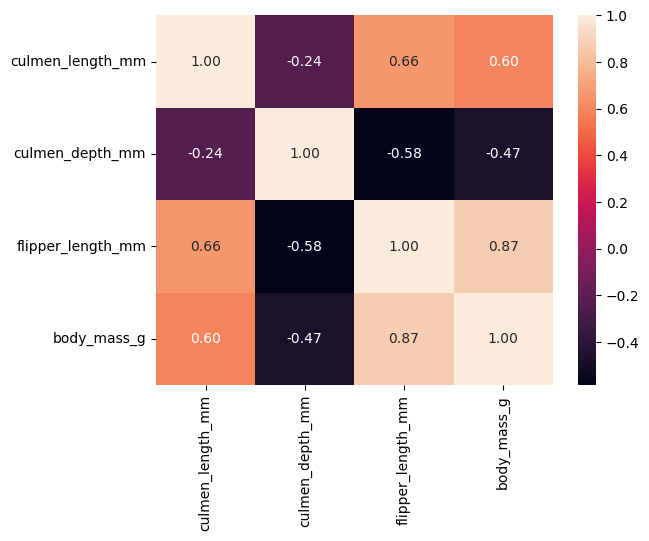

In [18]:
##The same in better way

sns.heatmap(pin.corr(numeric_only=True), annot = True, fmt=".2f")

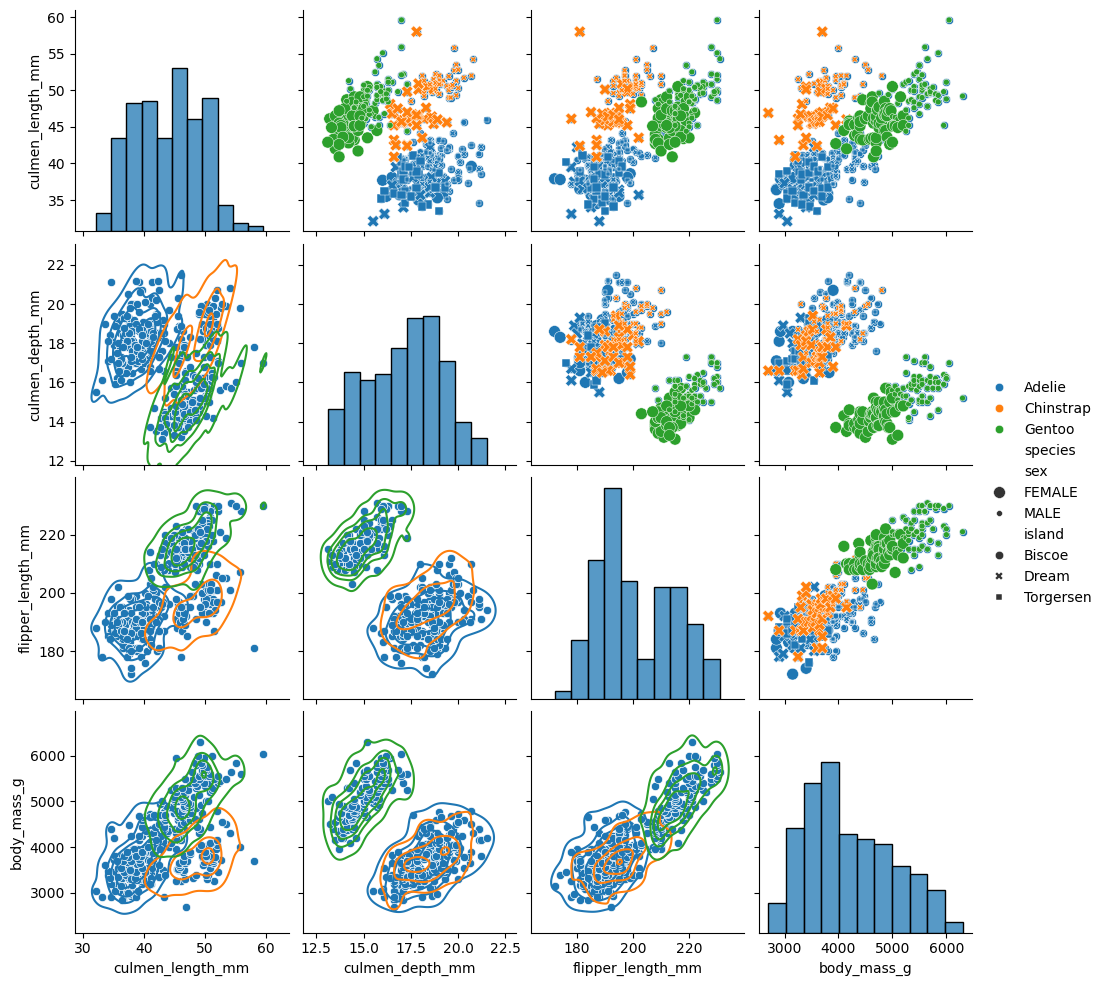

In [19]:
# Lets check how it looks like on charts 

p=sns.pairplot(pin)
p.map_lower(sns.kdeplot, levels=5, color=".3", hue=pin['species'])
p.map_upper(sns.scatterplot, size=pin["sex"], hue=pin['species'], style=pin['island'])
p.add_legend(title="", adjust_subtitles=True)

- there is a clear solution for culmen_depth vs filpper & culmen length
- body mass is in correlation with flipper length
- species depends mostly on body mass, flipper length and culmen length, so ...

# Hypothesis: we'll use classic logistic regression to sort spiecies (3 values) based on 2 variables: body mass & flipper length 

but, we still would like to examine culmen length influence, so later we'll see if multivariable regression would be good



/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(


<AxesSubplot:xlabel='body_mass_g', ylabel='flipper_length_mm'>

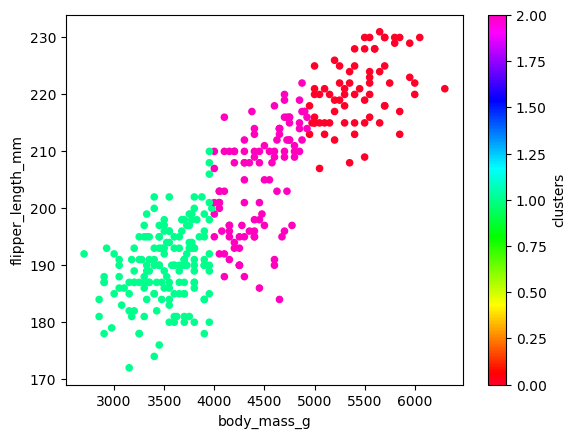

In [20]:
# let's see it for seperate columns
from sklearn.cluster import KMeans
m = KMeans(tmp['species'].unique().size, n_init='auto')
m.fit(tmp)
tmp['clusters'] = m.labels_
tmp.plot.scatter('body_mass_g','flipper_length_mm',c='clusters',colormap='gist_rainbow')

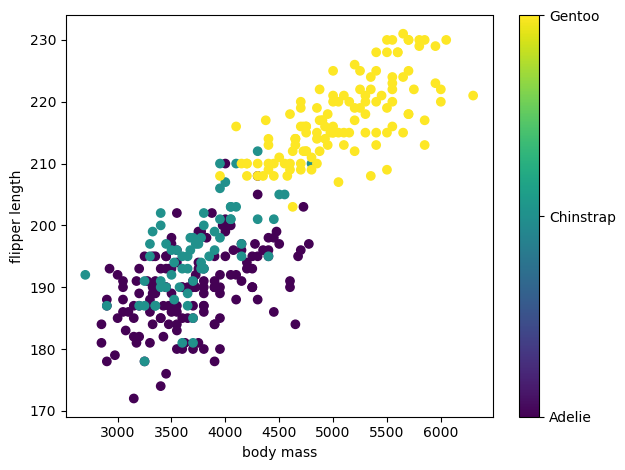

In [21]:
formatter = plt.FuncFormatter(lambda i, *args: pin['species'].unique()[int(i)])
plt.scatter(tmp['body_mass_g'], tmp['flipper_length_mm'], c=tmp['species'])
plt.xlabel('body mass')
plt.ylabel('flipper length')
plt.colorbar(ticks=[0,1,2], format=formatter)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier


def logisticRegressionByArgs(cols, model):
    x = pin.copy()[cols]
    y = pin.copy().pop('species')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1, stratify = y)
    print(f"Logistic regression for features: {cols}\n")
    model.fit(x_train[cols].values, y_train)
    #plot_decision_regions(x_train[cols].values, y_train.values, classifier=model)
    print(f"Score for this featureset is: {model.score(x_test[cols].values, y_test)}\n")
    plotConfusionMatrix(x_test, y_test, model)
    print(f"classificaiton report for this dataset:\n {classification_report(y_test, model.predict(x_test))}")
    
def plotConfusionMatrix(x,y,model):
    cm = confusion_matrix(y, model.predict(x))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted Adelie', 'Predicted Chinstrap', 'Predicted Gentoo'))
    ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual Adelie', 'Actual Chinstrap', 'Actual Gentoo'))
    #ax.set_ylim(1.5, -0.5)
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    print(f"The confusion matrix for this featureset is: \n {cm}")
    plt.show()
    
    
def plot_decision_regions(X, y, classifier, resolution=0.02):
      markers = ('o', 's', '^', 'v', '<')
      colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
      cmap = ListedColormap(colors[:len(np.unique(y))])
      # obszar wykresu
      x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                             np.arange(x2_min, x2_max, resolution))
      lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
      lab = lab.reshape(xx1.shape)
      plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
      plt.xlim(xx1.min(), xx1.max())
      plt.ylim(xx2.min(), xx2.max())

      # wykres punktowy obserwacji
      for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y == cl, 0],
                        y=X[y == cl, 1],
                        alpha=0.8,
                        c=colors[idx],
                        marker=markers[idx],
                        label=f'Class {cl}',
                        edgecolor='black')
            plt.legend()

#plot_decision_regions(x_train[cols].values, y_train.values, classifier=model)

# FIRST INTERACTION 
> We gonna try on **'body_mass_g','culmen_length_mm'** columns

Logistic regression for features: ['body_mass_g', 'culmen_length_mm']

Score for this featureset is: 0.9418604651162791



/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The confusion matrix for this featureset is: 
 [[37  0  1]
 [ 0 17  0]
 [ 4  0 27]]


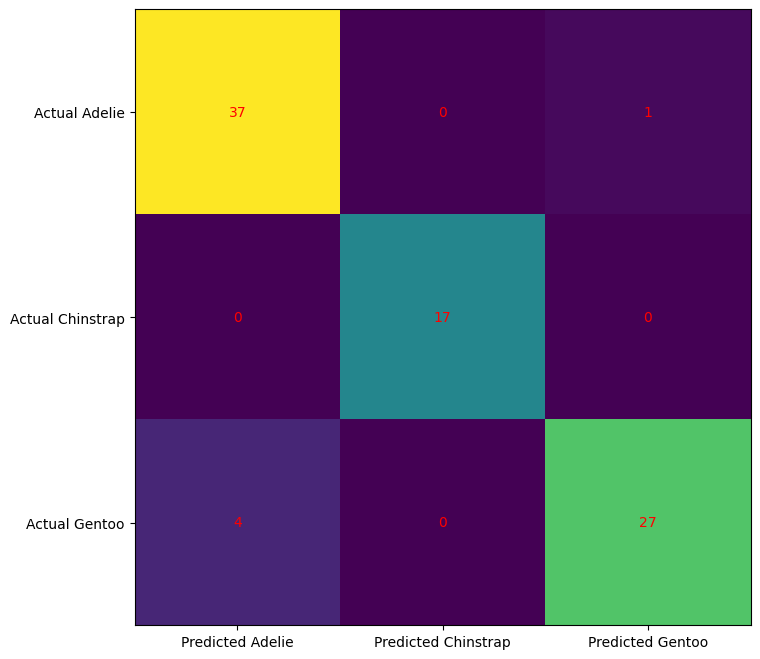

/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


classificaiton report for this dataset:
               precision    recall  f1-score   support

      Adelie       0.90      0.97      0.94        38
   Chinstrap       1.00      1.00      1.00        17
      Gentoo       0.96      0.87      0.92        31

    accuracy                           0.94        86
   macro avg       0.96      0.95      0.95        86
weighted avg       0.94      0.94      0.94        86



In [23]:
model = OneVsRestClassifier(LogisticRegression(C=100, solver="lbfgs", max_iter=300, multi_class='ovr'))
logisticRegressionByArgs(['body_mass_g','culmen_length_mm'],model)




*We have 94% - not bad but lets try find a better model*

# SECOND INTERACTION
> Lets use: **'body_mass_g','flipper_length_mm','culmen_length_mm'**

Logistic regression for features: ['body_mass_g', 'flipper_length_mm', 'culmen_length_mm']

Score for this featureset is: 0.9651162790697675



/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The confusion matrix for this featureset is: 
 [[37  0  1]
 [ 0 17  0]
 [ 2  0 29]]


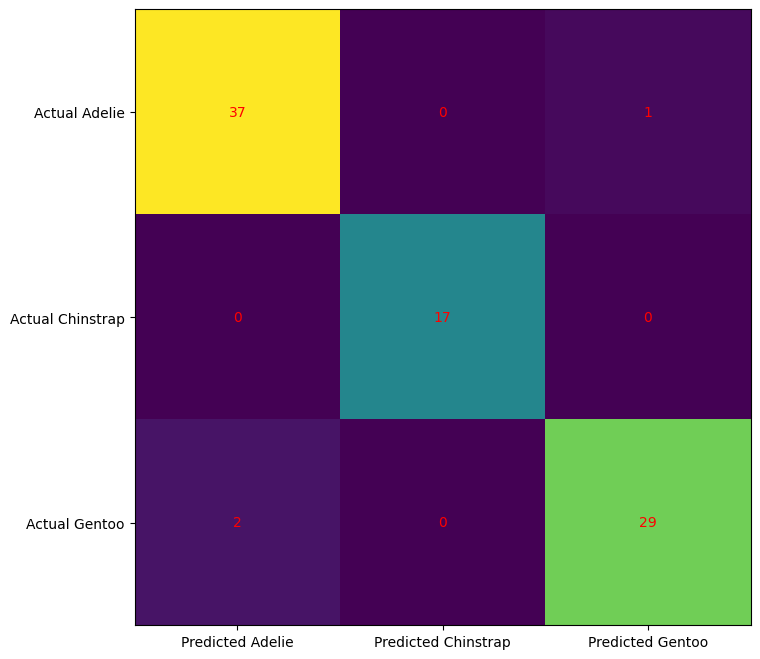

/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


classificaiton report for this dataset:
               precision    recall  f1-score   support

      Adelie       0.95      0.97      0.96        38
   Chinstrap       1.00      1.00      1.00        17
      Gentoo       0.97      0.94      0.95        31

    accuracy                           0.97        86
   macro avg       0.97      0.97      0.97        86
weighted avg       0.97      0.97      0.97        86



In [24]:
logisticRegressionByArgs(['body_mass_g','flipper_length_mm','culmen_length_mm'], model)



*Now we have 96,5%, better R2*

#  THIRD INTERACTION
> Maybe we will try on all primary float values - **'culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g'**

Logistic regression for features: ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

Score for this featureset is: 0.9883720930232558



/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The confusion matrix for this featureset is: 
 [[38  0  0]
 [ 1 16  0]
 [ 0  0 31]]


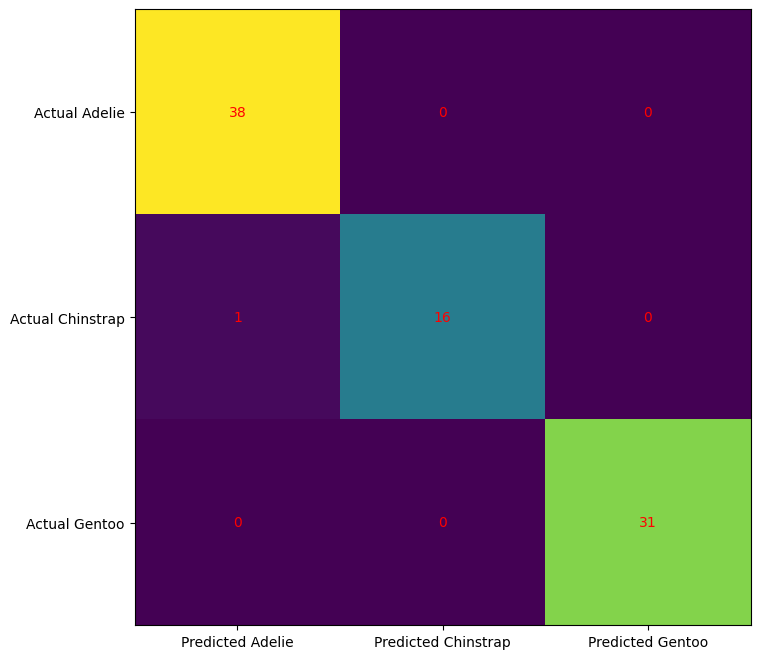

/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


classificaiton report for this dataset:
               precision    recall  f1-score   support

      Adelie       0.97      1.00      0.99        38
   Chinstrap       1.00      0.94      0.97        17
      Gentoo       1.00      1.00      1.00        31

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



In [25]:
logisticRegressionByArgs(['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g'], model)



*Now we have 98,8%, better R2*

#  FOURTH INTERACTION
> We gonna try with all data (also caterory columns) --

### But first prepare data 

In [26]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

pin["sex_nb"] = lb.fit_transform(pin["sex"])
pin['island_nb'] = lb.fit_transform(pin["island"])

pin.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_nb,island_nb
culmen_length_mm,1.000000,-0.235053,0.656181,0.595110,0.339701,-0.353647
culmen_depth_mm,-0.235053,1.000000,-0.583851,-0.471916,0.378129,0.571035
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202,0.237991,-0.565825
body_mass_g,0.595110,-0.471916,0.871202,1.000000,0.418654,-0.561515
sex_nb,0.339701,0.378129,0.237991,0.418654,1.000000,-0.002744
island_nb,-0.353647,0.571035,-0.565825,-0.561515,-0.002744,1.000000


<AxesSubplot:>

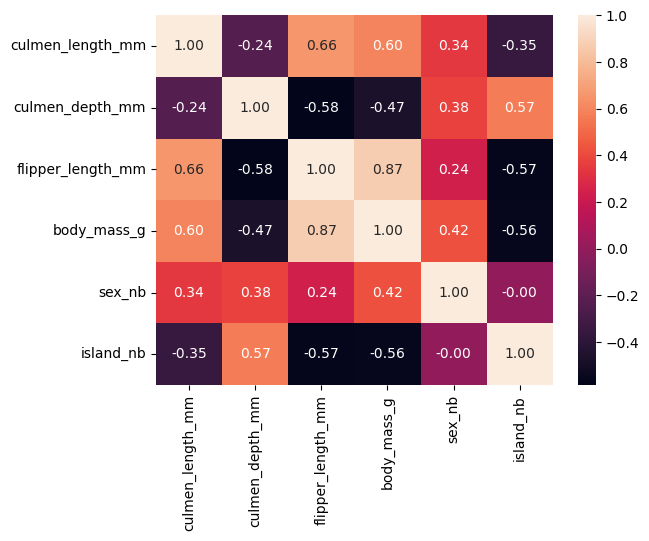

In [27]:
sns.heatmap(pin.corr(numeric_only=True), annot = True, fmt=".2f")

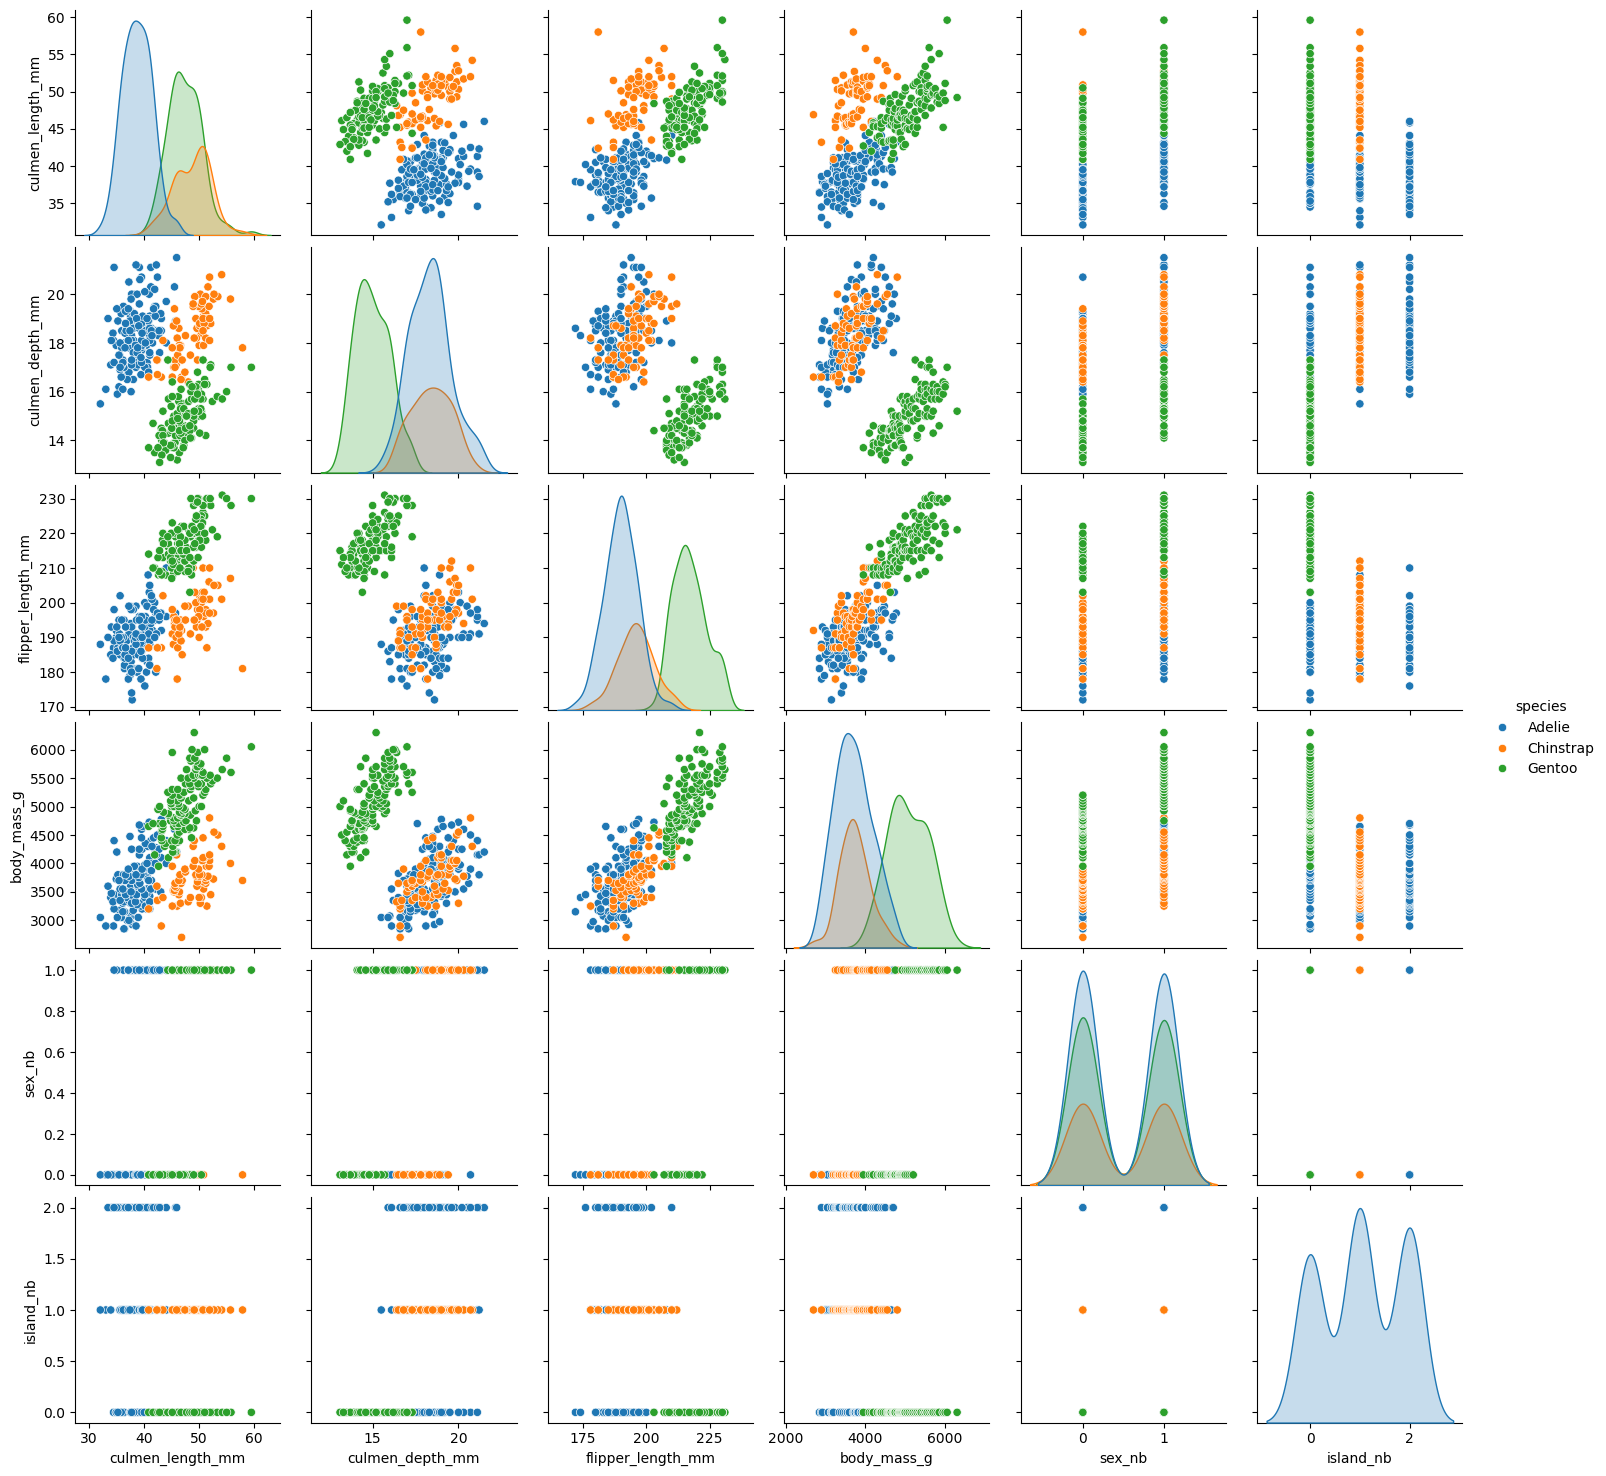

In [28]:
p=sns.pairplot(pin, hue='species')

> So lets do an interaction on columns : **'culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex_nb','island_nb'**

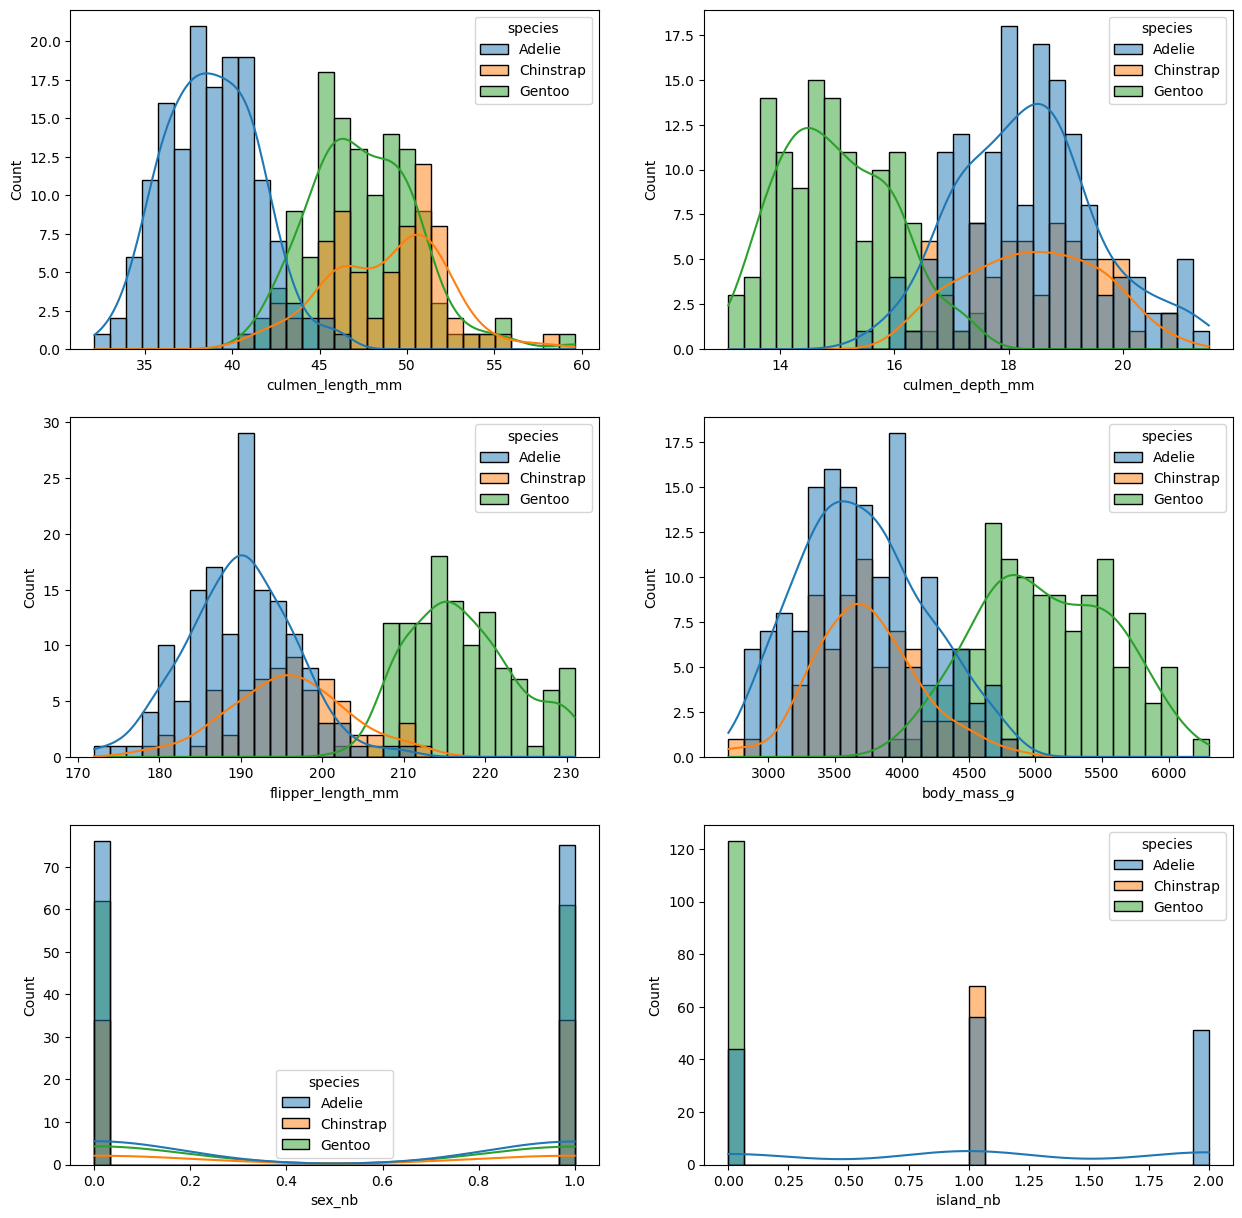

In [29]:
plt.figure(figsize=(15, 15))

plot_ent = pin[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex_nb','island_nb', 'species']]

for i, column in enumerate(plot_ent[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex_nb','island_nb']], 1):
    plt.subplot(3, 2, i)
    sns.histplot(plot_ent, x=plot_ent[column], hue=plot_ent['species'], kde=True, bins=30)
    plt.xlabel(column)

Logistic regression for features: ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_nb', 'island_nb']

Score for this featureset is: 0.9883720930232558



/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The confusion matrix for this featureset is: 
 [[38  0  0]
 [ 1 16  0]
 [ 0  0 31]]


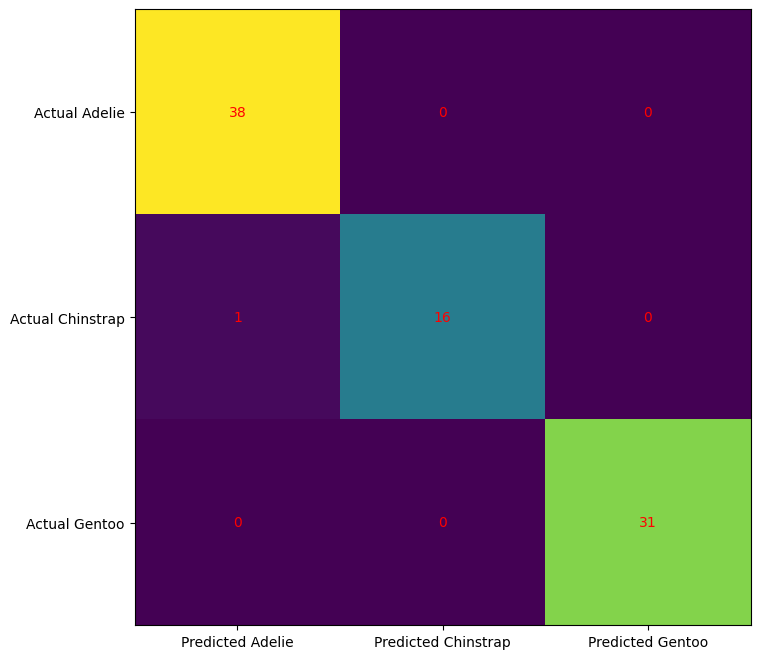

/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


classificaiton report for this dataset:
               precision    recall  f1-score   support

      Adelie       0.97      1.00      0.99        38
   Chinstrap       1.00      0.94      0.97        17
      Gentoo       1.00      1.00      1.00        31

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



In [30]:
logisticRegressionByArgs(['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex_nb','island_nb'], model)

## THE SAME INTERATION 
> We gonna try the same scope but in OLS model

In [31]:
    cols=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex_nb','island_nb']
    pin['species_nb'] = lb.fit_transform(pin["species"])
    x = pin.copy()[cols]
    y = pin['species_nb'].copy()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1, stratify = y)

In [32]:
X = sm.add_constant(x_train)
model_ols = sm.OLS(y_train, X)
result_ols = model_ols.fit()
print(result_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             species_nb   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     506.1
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          2.19e-136
Time:                        12:26:40   Log-Likelihood:                -3.5086
No. Observations:                 256   AIC:                             21.02
Df Residuals:                     249   BIC:                             45.83
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.1595      0.54

> We can see that **F1** is high, and most of values have very low **p-value** but the highest is for **body_mass_g**

# FIFTH INTERACTION

> OLS model without body_mass_g

In [33]:
    cols=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','sex_nb','island_nb']

    x = pin.copy()[cols]
    y = pin['species_nb'].copy()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1, stratify = y)

In [34]:
X = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)
model_ols = sm.OLS(y_train, X)
result_ols = model_ols.fit()
print(result_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             species_nb   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     596.9
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          9.78e-137
Time:                        12:26:44   Log-Likelihood:                -6.0226
No. Observations:                 256   AIC:                             24.05
Df Residuals:                     250   BIC:                             45.32
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.4480      0.52


> We can see that all values have 0 **p-value** that's means that every parameter is available here, **F1** was increased


# FOR FUN LETS TRY DECISION TREE

> 

In [35]:
from sklearn.tree import DecisionTreeClassifier

reg =  DecisionTreeClassifier()
reg.fit(x_train, y_train)

y_predict=reg.predict(x_test)


In [36]:
from sklearn.metrics import accuracy_score

def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        pred = clf.predict(x_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True, target_names = pd.unique(pin['species'].values)))
        print("Train Result:\n================================================")
        print(f"Accuracy Train Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION TRAIN REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Train Matrix: \n {confusion_matrix(y_train, pred)}\n")
        print("_______________________________________________")

        
    elif train==False:
        pred = clf.predict(x_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True,  target_names = pd.unique(pin['species'].values)))
        print("Test Result:\n================================================")        
        print(f"Accuracy Test Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION TEST REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Test Matrix: \n {confusion_matrix(y_test, pred)}\n")
        print("_______________________________________________")


In [37]:
print_score(reg, x_train, y_train, x_test, y_test, train=True)
print_score(reg, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Train Score: 100.00%
_______________________________________________
CLASSIFICATION TRAIN REPORT:
           Adelie  Chinstrap  Gentoo  accuracy  macro avg  weighted avg
precision     1.0        1.0     1.0       1.0        1.0           1.0
recall        1.0        1.0     1.0       1.0        1.0           1.0
f1-score      1.0        1.0     1.0       1.0        1.0           1.0
support     113.0       51.0    92.0       1.0      256.0         256.0
_______________________________________________
Confusion Train Matrix: 
 [[113   0   0]
 [  0  51   0]
 [  0   0  92]]

_______________________________________________
Test Result:
Accuracy Test Score: 98.84%
_______________________________________________
CLASSIFICATION TEST REPORT:
              Adelie  Chinstrap     Gentoo  accuracy  macro avg  weighted avg
precision   0.974359        1.0   1.000000  0.988372   0.991453      0.988670
recall      1.000000        1.0   0.967742  0.988372   0.989247      0.988372





# >>>>>CONCLUSION: <<<<<
> The best model is in ***FOURTH INTERACTION*** with all data, we are getting very high **R2**, and only **1** row from test dataset was assigned in wrong cattegory
>
> Generally whole dataset would allow as to predict quite a good data
>
> Lets do some play with parapeters in Logistic Regression model:

Logistic regression for features: ['body_mass_g', 'flipper_length_mm', 'culmen_length_mm']

Score for this featureset is: 0.9651162790697675



/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The confusion matrix for this featureset is: 
 [[37  0  1]
 [ 0 17  0]
 [ 2  0 29]]


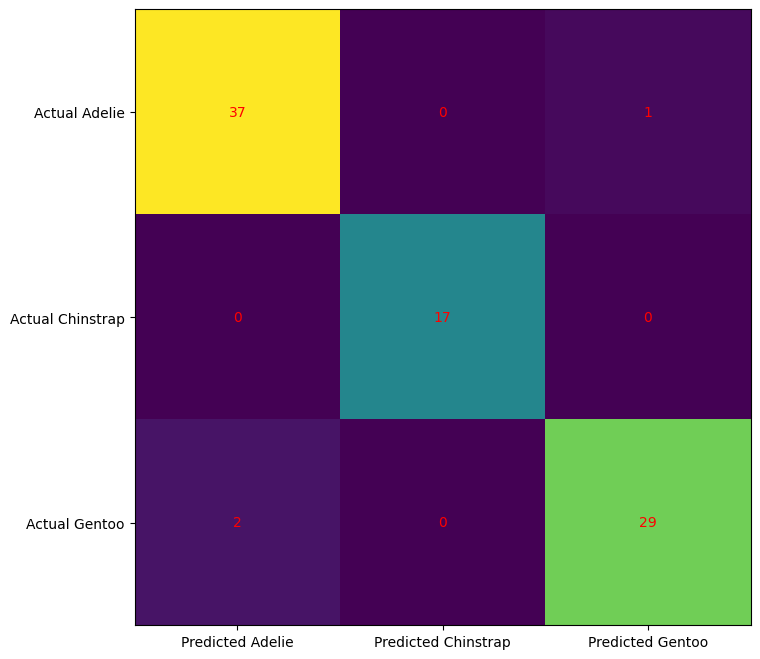

/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


classificaiton report for this dataset:
               precision    recall  f1-score   support

      Adelie       0.95      0.97      0.96        38
   Chinstrap       1.00      1.00      1.00        17
      Gentoo       0.97      0.94      0.95        31

    accuracy                           0.97        86
   macro avg       0.97      0.97      0.97        86
weighted avg       0.97      0.97      0.97        86



In [38]:
# let's tweak the C value to try to improve our model...
model = OneVsRestClassifier(LogisticRegression(C=1000, solver="lbfgs", max_iter=100, multi_class='ovr'))
logisticRegressionByArgs(['body_mass_g','flipper_length_mm','culmen_length_mm'],model)

Logistic regression for features: ['body_mass_g', 'flipper_length_mm', 'culmen_length_mm']

Score for this featureset is: 0.9651162790697675



/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The confusion matrix for this featureset is: 
 [[37  0  1]
 [ 0 17  0]
 [ 2  0 29]]


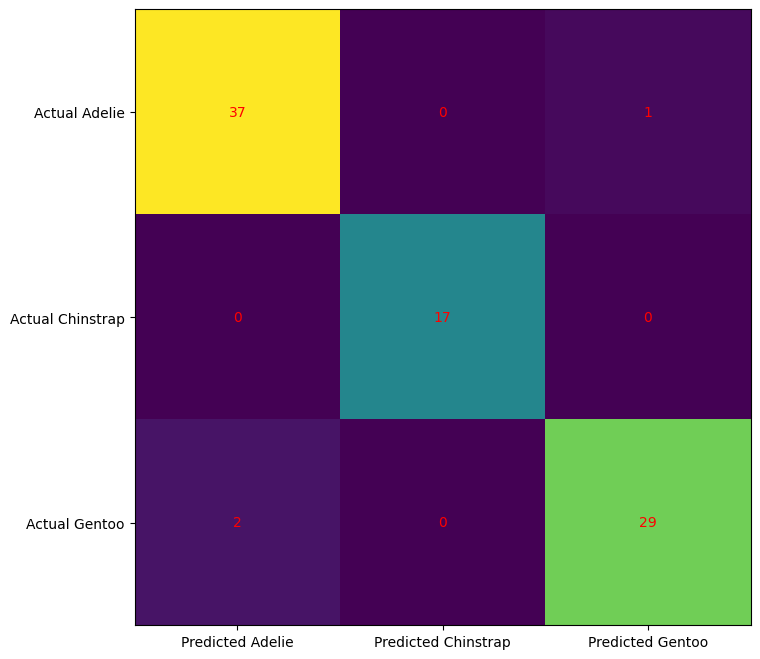

/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


classificaiton report for this dataset:
               precision    recall  f1-score   support

      Adelie       0.95      0.97      0.96        38
   Chinstrap       1.00      1.00      1.00        17
      Gentoo       0.97      0.94      0.95        31

    accuracy                           0.97        86
   macro avg       0.97      0.97      0.97        86
weighted avg       0.97      0.97      0.97        86



In [39]:
model = OneVsRestClassifier(LogisticRegression(C=10, solver="lbfgs", max_iter=100, multi_class='ovr'))
logisticRegressionByArgs(['body_mass_g','flipper_length_mm','culmen_length_mm'],model)

looks like strength regularization does not make any difference on this dataset
let's play with solver, we can only choose lbfgs, newton-cg or sag(a) due to having 3 output classes (we;d need to convert them into "not in class..." to use liblinear or newton-cholesky)

Logistic regression for features: ['body_mass_g', 'flipper_length_mm', 'culmen_length_mm']



/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/lib/python3.11/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Score for this featureset is: 0.9883720930232558



/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The confusion matrix for this featureset is: 
 [[37  1  0]
 [ 0 17  0]
 [ 0  0 31]]


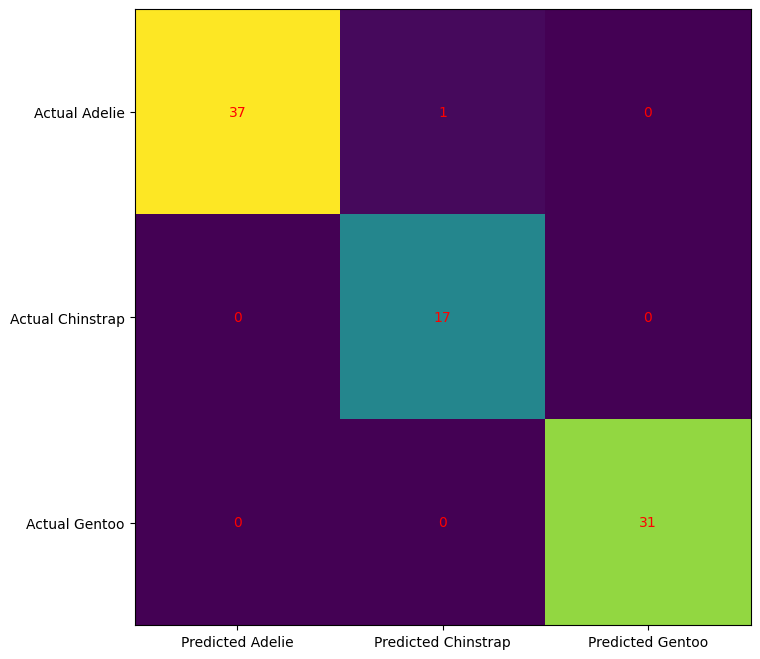

/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


classificaiton report for this dataset:
               precision    recall  f1-score   support

      Adelie       1.00      0.97      0.99        38
   Chinstrap       0.94      1.00      0.97        17
      Gentoo       1.00      1.00      1.00        31

    accuracy                           0.99        86
   macro avg       0.98      0.99      0.99        86
weighted avg       0.99      0.99      0.99        86



In [40]:
model = LogisticRegression(C=100, solver="newton-cg", max_iter=100, multi_class='ovr')
logisticRegressionByArgs(['body_mass_g','flipper_length_mm','culmen_length_mm'],model)

> **A Little bit better score!!**

Logistic regression for features: ['body_mass_g', 'culmen_length_mm']



/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for this featureset is: 0.36046511627906974



/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The confusion matrix for this featureset is: 
 [[ 0  0 38]
 [ 0  0 17]
 [ 0  0 31]]


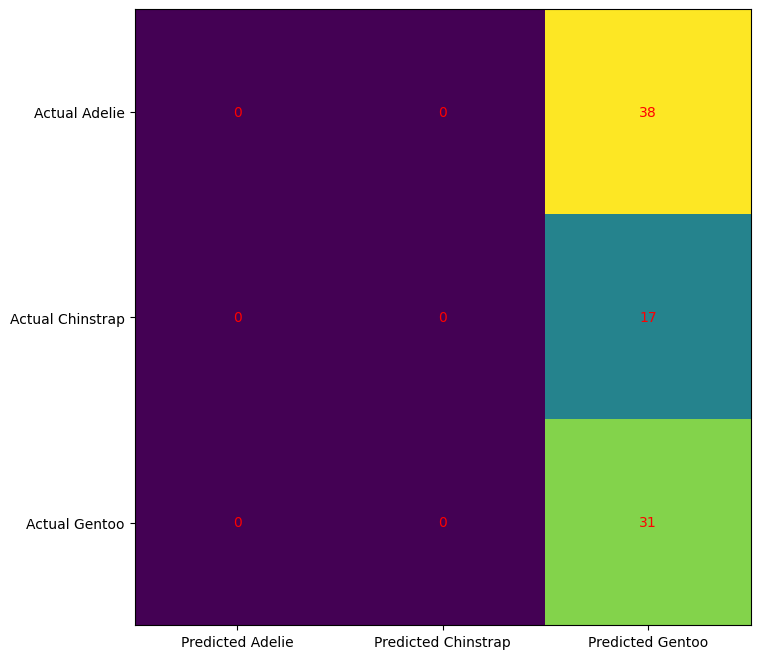

/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

classificaiton report for this dataset:
               precision    recall  f1-score   support

      Adelie       0.00      0.00      0.00        38
   Chinstrap       0.00      0.00      0.00        17
      Gentoo       0.36      1.00      0.53        31

    accuracy                           0.36        86
   macro avg       0.12      0.33      0.18        86
weighted avg       0.13      0.36      0.19        86



In [41]:
#one last chance - change number of iterations - the below code will degrade accuracy significantly
model = LogisticRegression(C=100, solver="lbfgs", max_iter=10, multi_class='ovr')
logisticRegressionByArgs(['body_mass_g','culmen_length_mm'],model)

### Conclusions for PLAYING PARAMETERS
- max_iter will have significant outcome, should be adjusted to n umber of test items
- C value will not have much of effect here
- the most significant effect (accuracy) will happen when we choose good corelated data